# Mod 4 Project - Starter Notebook

In this project, we will take a look at a zillow dataset on the housing prices.


## Outline:

<ul>
    <li>Abstract</li>
    <li>Load and preprocess the data</li>
    <li>Filter for the desired area</li>
    <li>Find the best model to use for making predictions</li>
    <li>Graph predictions of our data</li>
    <li>Summary of the results</li>
</ul>

## Abstract 

The area that we will be looking at for this project is Central Florida.

We are going to create a time series model to find the best zip code to buy homes within this county of Florida.

![map of Orange County, Florda](images/769-orange-county-florida.jpg)

### Import libraries to run notebook

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import helper_functions as hf
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
data_wide = pd.read_csv('./zillow_data.csv')

In [3]:
data_wide.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
data_long = hf.melt_data_v2(data_wide)
data_long['time'] = pd.to_datetime(data_long['time'], format='%Y-%m-%d')
data_long['RegionName'] = data_long['RegionName'].astype('str')

data_long.set_index(keys='time', inplace=True)
data_long.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


## Filter for the desired area within Florida

In this project, we will be looing at zip codes in Florida, specifically areas near Orlando

In [5]:
#separate out areas within the state of Florida
df_fl = data_long.loc[data_long.State=='FL']
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


In [6]:
df_fl.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         7155
CountyName       0
SizeRank         0
value            0
dtype: int64

Since the Metro area has a large amount of information that is missing, this column will not be used, although it is a good label of where homes are located related to nearest cities.  

We will use county inplace of metro area to identify the housing areas.

The benefit of using county as well is that there is not a great difference the unique counties and metro-areas within the state of Florida

In [7]:
print(f"Number of unique Metro areas in FL: {df_fl.Metro.nunique()}" + 
        f"\nNumber of unique counties in FL: {df_fl.CountyName.nunique()}" + 
     f"\nNumber of unique cities in FL: {df_fl.City.nunique()}")

Number of unique Metro areas in FL: 28
Number of unique counties in FL: 57
Number of unique cities in FL: 401


In [8]:
df_fl.info()
df_fl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


# Step 2: Data Preprocessing

# Step 3: EDA and Visualization

In [9]:
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [11]:
df_fl.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


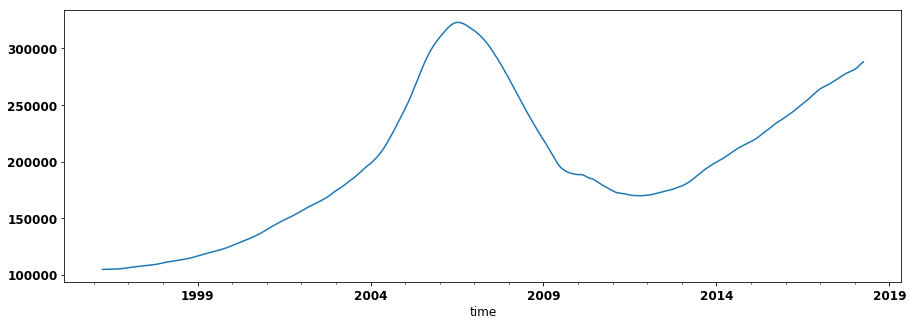

In [12]:
# Florida monthly means ovre the years
florida_monthly = df_fl.groupby(pd.Grouper(freq='MS'))
florida_monthly.value.mean().plot(figsize=(15,5))

In [13]:
# Separate out the areas that are part of Central Florida
central_florida = ['Levy', 'Marion', 'Volusia', 'Citrus', 'Sumter',
                           'Lake', 'Seminole', 'Hernando', 'Orange', 'Brevard', 'Pasco',
                           'Pinellas', 'Hillsborough', 'Polk', ' Osceola', 'Indian River']

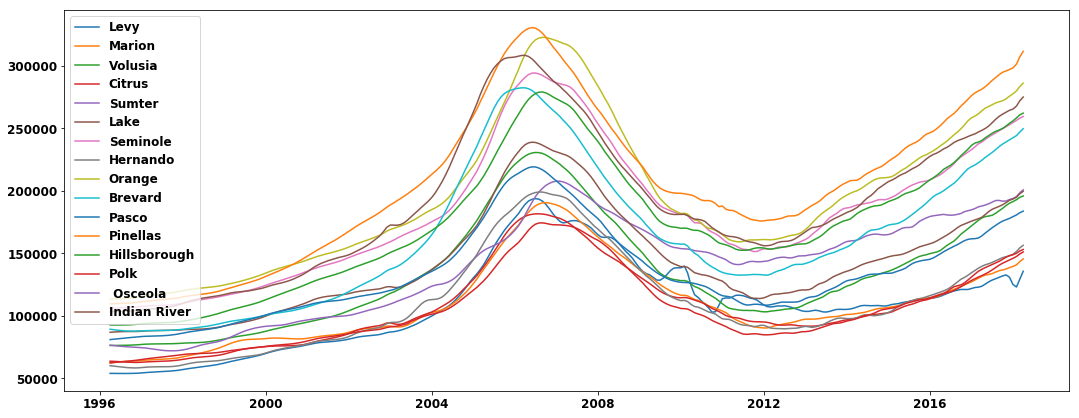

In [14]:
#Plot the means for each county in Central Florida
plt.figure(figsize=(18,7))

for county in central_florida:    
    county_df = df_fl.loc[(df_fl.CountyName==county), ['value']].resample('MS').mean()
    plt.plot(county_df, label=county)
plt.legend()
plt.show()

# df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

Overall, Central FLorida's counties resemble the entire state of Florida.  Each of these counties were affected by the housing market crash, but some were affected more than others.

Based on our graph below, there appears to be some seasonality that is occurring within the housing market for orange county as time passes by.

TO create our model, we will look at the average of Central Florida's mean prices by month. 

In [16]:
central_fl = df_fl.loc[(df_fl.CountyName.isin(central_florida)), ['value']].resample('MS').mean()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


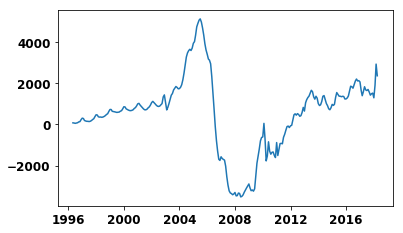

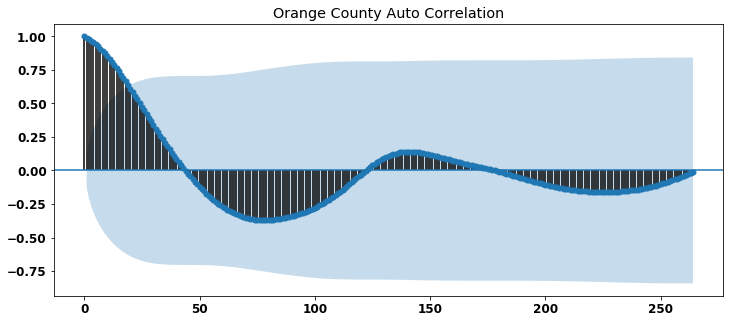

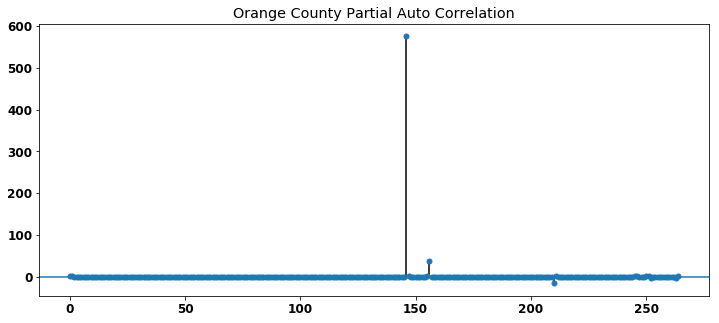

In [17]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation

plt.gcf().autofmt_xdate()

central_fl_diff = central_fl.diff(periods=1)
rcParams['figure.figsize'] = (12, 5)
plt.plot(central_fl_diff)

rcParams['figure.figsize'] = (12, 5)
plot_acf(central_fl['value'], title='Orange County Auto Correlation');
plot_pacf(central_fl['value'], title='Orange County Partial Auto Correlation');

Based on what we see in our partial correlation plot, there is a high negative correlation somewhere between 220 - 245 lags.

This high negative appears at lag = 180 months

# Step 4: Reshape from Wide to Long Format

In [18]:
central_fl.head()

,value
time,
1996-04-01,87852.076677
1996-05-01,87926.198083
1996-06-01,87991.693291
1996-07-01,88042.492013
1996-08-01,88106.389776


# Step 5: ARIMA Modeling

Before getting into the ARIMA modeling, combinations for the model needs to be created.  
Here, the parameters for all combinations of seasons are also added to our values for seasonal & non seasonal arima modeling.

In [19]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Generate combinations of SARIMA modeling with different seasonalities
pdqs = []    
for i in range(0,13):
    for x in pdq:
        pdqs.append((x[0], x[1], x[2], i))

pdqs

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 1),
 (0, 1, 0, 1),
 (0, 1, 1, 1),
 (1, 0, 0, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 4),
 (0, 1, 0, 4),
 (0, 1, 1, 4),
 (1, 0, 0, 4),
 (1, 0, 1, 4),
 (1, 1, 0, 4),
 (1, 1, 1, 4),
 (0, 0, 0, 5),
 (0, 0, 1, 5),
 (0, 1, 0, 5),
 (0, 1, 1, 5),
 (1, 0, 0, 5),
 (1, 0, 1, 5),
 (1, 1, 0, 5),
 (1, 1, 1, 5),
 (0, 0, 0, 6),
 (0, 0, 1, 6),
 (0, 1, 0, 6),
 (0, 1, 1, 6),
 (1, 0, 0, 6),
 (1, 0, 1, 6),
 (1, 1, 0, 6),
 (1, 1, 1, 6),
 (0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (0, 0, 0, 8),
 (0, 0, 1, 8),
 (0, 1, 0,

In [20]:
## Run multiple models with the different combination generated  for pdq & pdqs##
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = hf.model_SARIMA(df=central_fl, order=comb, s_order=combs)
            ans.append([comb, combs, mod.aic, mod.bic])
            print('ARIMA {} x {} : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, mod.aic, mod.bic))
        except:
            continue

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA (0, 0, 0) x (0, 0, 0, 0) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 0) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 0) x (1, 0, 0, 0) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (0, 0, 0) x (1, 0, 1, 0) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (0, 0, 0) x (0, 0, 0, 1) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 1) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 0) x (0, 1, 0, 1) : AIC Calculated =4714.914363638998, BIC Calculated =4718.4865176711755
ARIMA (0, 0, 0) x (0, 1, 1, 1) : AIC Calculated =4353.738444144726, BIC Calculated =4360.875133152248
ARIMA (0, 0, 0) x (1, 0, 0, 1) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (0, 0, 0) x (1, 0, 1, 1) : AIC Calculated =4352.49323085384, BIC Calculated =4363.20

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 4) : AIC Calculated =4722.810587546359, BIC Calculated =4733.446119879797
ARIMA (0, 0, 0) x (0, 0, 0, 5) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 5) : AIC Calculated =6779.8298083958425, BIC Calculated =6786.943464519241
ARIMA (0, 0, 0) x (0, 1, 0, 5) : AIC Calculated =5472.692440906639, BIC Calculated =5476.249268968339


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 5) : AIC Calculated =5356.461670480157, BIC Calculated =5363.536339014195
ARIMA (0, 0, 0) x (1, 0, 0, 5) : AIC Calculated =5479.139914156663, BIC Calculated =5486.261277418694
ARIMA (0, 0, 0) x (1, 0, 1, 5) : AIC Calculated =5398.907144557856, BIC Calculated =5409.577628742954
ARIMA (0, 0, 0) x (1, 1, 0, 5) : AIC Calculated =4890.656847530968, BIC Calculated =4897.739374621285
ARIMA (0, 0, 0) x (1, 1, 1, 5) : AIC Calculated =4865.997100322535, BIC Calculated =4876.60910312359
ARIMA (0, 0, 0) x (0, 0, 0, 6) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 6) : AIC Calculated =56391.6788287698, BIC Calculated =56398.784747939644
ARIMA (0, 0, 0) x (0, 1, 0, 6) : AIC Calculated =5544.558494753708, BIC Calculated =5548.11145433863


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 6) : AIC Calculated =5413.180039954949, BIC Calculated =5420.238898129972
ARIMA (0, 0, 0) x (1, 0, 0, 6) : AIC Calculated =5552.218798540664, BIC Calculated =5559.332454664062
ARIMA (0, 0, 0) x (1, 0, 1, 6) : AIC Calculated =5469.66763370335, BIC Calculated =5480.326512458115
ARIMA (0, 0, 0) x (1, 1, 0, 6) : AIC Calculated =5008.105185998018, BIC Calculated =5015.171964975473
ARIMA (0, 0, 0) x (1, 1, 1, 6) : AIC Calculated =4982.009137874149, BIC Calculated =4992.597425136683
ARIMA (0, 0, 0) x (0, 0, 0, 7) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 7) : AIC Calculated =64248.78578734947, BIC Calculated =64255.88393951926
ARIMA (0, 0, 0) x (0, 1, 0, 7) : AIC Calculated =5601.138482685596, BIC Calculated =5604.687558770491


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 7) : AIC Calculated =5450.291987079256, BIC Calculated =5457.334908914981
ARIMA (0, 0, 0) x (1, 0, 0, 7) : AIC Calculated =5609.901484775457, BIC Calculated =5617.0074039453
ARIMA (0, 0, 0) x (1, 0, 1, 7) : AIC Calculated =5525.464209588703, BIC Calculated =5536.111437843389
ARIMA (0, 0, 0) x (1, 1, 0, 7) : AIC Calculated =5100.179237145479, BIC Calculated =5107.230143023743
ARIMA (0, 0, 0) x (1, 1, 1, 7) : AIC Calculated =5074.094915524267, BIC Calculated =5084.659298277854
ARIMA (0, 0, 0) x (0, 0, 0, 8) : AIC Calculated =7090.036087884773, BIC Calculated =7093.61203698792
ARIMA (0, 0, 0) x (0, 0, 1, 8) : AIC Calculated =72134.95684802921, BIC Calculated =72142.04720291817
ARIMA (0, 0, 0) x (0, 1, 0, 8) : AIC Calculated =5646.484640949277, BIC Calculated =5650.029818393756
ARIMA (0, 0, 0) x (0, 1, 1, 8) : AIC Calculated =5478.381310647997, BIC Calculated =5485.408168140328
ARIMA (0, 0, 0) x (1, 0, 0, 8) : AIC Calculated =5656.261289193389, BIC Calculated =5

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated =5316.704391629399, BIC Calculated =5327.146308399425
ARIMA (0, 0, 1) x (0, 0, 0, 0) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 0) : AIC Calculated =6807.459922032849, BIC Calculated =6818.164955544133
ARIMA (0, 0, 1) x (1, 0, 0, 0) : AIC Calculated =6806.270063429398, BIC Calculated =6816.986525525931
ARIMA (0, 0, 1) x (1, 0, 1, 0) : AIC Calculated =6782.409007959643, BIC Calculated =6796.682385974687
ARIMA (0, 0, 1) x (0, 0, 0, 1) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 1) : AIC Calculated =6807.459922032849, BIC Calculated =6818.164955544133
ARIMA (0, 0, 1) x (0, 1, 0, 1) : AIC Calculated =4353.738444144726, BIC Calculated =4360.875133152248
ARIMA (0, 0, 1) x (0, 1, 1, 1) : AIC Calculated =4552.177321761912, BIC Calculated =4562.87088298388
ARIMA (0, 0, 1) x (1, 0, 0, 1) : AIC Calculated =6806.270063429398, BIC Calculated =6816

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 2) : AIC Calculated =4381.4989560768545, BIC Calculated =4395.726268323652
ARIMA (0, 0, 1) x (0, 0, 0, 3) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 3) : AIC Calculated =34249.84328699539, BIC Calculated =34260.525331888435
ARIMA (0, 0, 1) x (0, 1, 0, 3) : AIC Calculated =5048.001007858244, BIC Calculated =5055.122371120275


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 3) : AIC Calculated =4796.193787671671, BIC Calculated =4806.841015926357
ARIMA (0, 0, 1) x (1, 0, 0, 3) : AIC Calculated =6780.483947828954, BIC Calculated =6791.188981340238
ARIMA (0, 0, 1) x (1, 0, 1, 3) : AIC Calculated =8067.082277544205, BIC Calculated =8081.325004068267
ARIMA (0, 0, 1) x (1, 1, 0, 3) : AIC Calculated =4471.597809097169, BIC Calculated =4482.268293282268
ARIMA (0, 0, 1) x (1, 1, 1, 3) : AIC Calculated =5181.861536041741, BIC Calculated =5196.0578403813215
ARIMA (0, 0, 1) x (0, 0, 0, 4) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 4) : AIC Calculated =41659.73607437, BIC Calculated =41670.40655855509
ARIMA (0, 0, 1) x (0, 1, 0, 4) : AIC Calculated =5175.769224964553, BIC Calculated =5182.882881087952
ARIMA (0, 0, 1) x (0, 1, 1, 4) : AIC Calculated =6906.787418199703, BIC Calculated =6917.4112088351785
ARIMA (0, 0, 1) x (1, 0, 0, 4) : AIC Calculated =8738.917143012724, BIC Calculated =87

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 4) : AIC Calculated =4466.14443988535, BIC Calculated =4480.309494065984
ARIMA (0, 0, 1) x (0, 0, 0, 5) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 5) : AIC Calculated =7484.734428181984, BIC Calculated =7495.3933069367495
ARIMA (0, 0, 1) x (0, 1, 0, 5) : AIC Calculated =5269.158750435155, BIC Calculated =5276.264669604998
ARIMA (0, 0, 1) x (0, 1, 1, 5) : AIC Calculated =4992.8941845975205, BIC Calculated =5003.494353063703
ARIMA (0, 0, 1) x (1, 0, 0, 5) : AIC Calculated =8070.397491150758, BIC Calculated =8081.079536043804
ARIMA (0, 0, 1) x (1, 0, 1, 5) : AIC Calculated =6679.185798300001, BIC Calculated =6693.397636639687
ARIMA (0, 0, 1) x (1, 1, 0, 5) : AIC Calculated =4791.674555518041, BIC Calculated =4802.298346153517


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 5) : AIC Calculated =4675.427643852374, BIC Calculated =4689.561201807284
ARIMA (0, 0, 1) x (0, 0, 0, 6) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 6) : AIC Calculated =57972.330417483674, BIC Calculated =57982.97764573836
ARIMA (0, 0, 1) x (0, 1, 0, 6) : AIC Calculated =5364.500618861276, BIC Calculated =5371.5987710310665
ARIMA (0, 0, 1) x (0, 1, 1, 6) : AIC Calculated =7117.196358320711, BIC Calculated =7127.772717138106
ARIMA (0, 0, 1) x (1, 0, 0, 6) : AIC Calculated =7712.643716006434, BIC Calculated =7723.314200191533
ARIMA (0, 0, 1) x (1, 0, 1, 6) : AIC Calculated =7319.987445496916, BIC Calculated =7334.183749836497
ARIMA (0, 0, 1) x (1, 1, 0, 6) : AIC Calculated =5202.398620742734, BIC Calculated =5212.998789208917
ARIMA (0, 0, 1) x (1, 1, 1, 6) : AIC Calculated =6508.948046557463, BIC Calculated =6523.049858313991
ARIMA (0, 0, 1) x (0, 0, 0, 7) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 7) : AIC Calculated =57051.28796579083, BIC Calculated =57061.92349812426
ARIMA (0, 0, 1) x (0, 1, 0, 7) : AIC Calculated =5397.371802954175, BIC Calculated 

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 7) : AIC Calculated =5086.170860393359, BIC Calculated =5096.7232190827535
ARIMA (0, 0, 1) x (1, 0, 0, 7) : AIC Calculated =6677.396224933298, BIC Calculated =6688.055103688063
ARIMA (0, 0, 1) x (1, 0, 1, 7) : AIC Calculated =7193.277063461502, BIC Calculated =7207.45777323942
ARIMA (0, 0, 1) x (1, 1, 0, 7) : AIC Calculated =5254.995888493941, BIC Calculated =5265.572247311336


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 7) : AIC Calculated =6796.019560978458, BIC Calculated =6810.089372564316
ARIMA (0, 0, 1) x (0, 0, 0, 8) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 8) : AIC Calculated =64731.45471246194, BIC Calculated =64742.078503097415
ARIMA (0, 0, 1) x (0, 1, 0, 8) : AIC Calculated =5393.616648497786, BIC Calculated =5400.699175588103


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 8) : AIC Calculated =5671.188226977698, BIC Calculated =5681.716391987582
ARIMA (0, 0, 1) x (1, 0, 0, 8) : AIC Calculated =6651.926026213199, BIC Calculated =6662.573254467885
ARIMA (0, 0, 1) x (1, 0, 1, 8) : AIC Calculated =7093.64970400796, BIC Calculated =7107.814758188594
ARIMA (0, 0, 1) x (1, 1, 0, 8) : AIC Calculated =5267.500842879707, BIC Calculated =5278.0532015691015
ARIMA (0, 0, 1) x (1, 1, 1, 8) : AIC Calculated =6852.02272707573, BIC Calculated =6866.060280422242
ARIMA (0, 0, 1) x (0, 0, 0, 9) : AIC Calculated =6872.806440442, BIC Calculated =6879.950748506356
ARIMA (0, 0, 1) x (0, 0, 1, 9) : AIC Calculated =7013.7322359571735, BIC Calculated =7024.344238758229
ARIMA (0, 0, 1) x (0, 1, 0, 9) : AIC Calculated =5479.507962274837, BIC Calculated =5486.5826308088745
ARIMA (0, 0, 1) x (0, 1, 1, 9) : AIC Calculated =7334.50054509439, BIC Calculated =7345.004319726024
ARIMA (0, 0, 1) x (1, 0, 0, 9) : AIC Calculated =6625.942855353131, BIC Calculated =6

ARIMA (0, 1, 0) x (0, 0, 1, 6) : AIC Calculated =4373.5700102650335, BIC Calculated =4380.668162434824
ARIMA (0, 1, 0) x (0, 1, 0, 6) : AIC Calculated =4226.3107479868, BIC Calculated =4229.859824071696
ARIMA (0, 1, 0) x (0, 1, 1, 6) : AIC Calculated =4113.23111238765, BIC Calculated =4120.282018265913
ARIMA (0, 1, 0) x (1, 0, 0, 6) : AIC Calculated =4231.9994341337115, BIC Calculated =4239.105353303555
ARIMA (0, 1, 0) x (1, 0, 1, 6) : AIC Calculated =4359.967964109199, BIC Calculated =4370.6151923638845
ARIMA (0, 1, 0) x (1, 1, 0, 6) : AIC Calculated =4116.988245331971, BIC Calculated =4124.047103506993
ARIMA (0, 1, 0) x (1, 1, 1, 6) : AIC Calculated =4103.42161976396, BIC Calculated =4113.997978581355
ARIMA (0, 1, 0) x (0, 0, 0, 7) : AIC Calculated =4714.914363638998, BIC Calculated =4718.4865176711755
ARIMA (0, 1, 0) x (0, 0, 1, 7) : AIC Calculated =4374.170306576837, BIC Calculated =4381.260661465796
ARIMA (0, 1, 0) x (0, 1, 0, 7) : AIC Calculated =4263.472840741639, BIC Calculated

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 3) : AIC Calculated =3761.241721141604, BIC Calculated =3775.4690333884023
ARIMA (0, 1, 1) x (1, 1, 0, 3) : AIC Calculated =3778.974726566563, BIC Calculated =3789.6336053213277
ARIMA (0, 1, 1) x (1, 1, 1, 3) : AIC Calculated =3721.8793980607825, BIC Calculated =3736.060107838701
ARIMA (0, 1, 1) x (0, 0, 0, 4) : AIC Calculated =4353.738444144726, BIC Calculated =4360.875133152248
ARIMA (0, 1, 1) x (0, 0, 1, 4) : AIC Calculated =4020.2242838053235, BIC Calculated =4030.8831625600883
ARIMA (0, 1, 1) x (0, 1, 0, 4) : AIC Calculated =3897.6151748236525, BIC Calculated =3904.7210939934957
ARIMA (0, 1, 1) x (0, 1, 1, 4) : AIC Calculated =3705.4906102680607, BIC Calculated =3716.102613069116
ARIMA (0, 1, 1) x (1, 0, 0, 4) : AIC Calculated =4293.499127342839, BIC Calculated =4304.181172235885
ARIMA (0, 1, 1) x (1, 0, 1, 4) : AIC Calculated =3760.773541181637, BIC Calculated =3774.9853795213235
ARIMA (0, 1, 1) x (1, 1, 0, 4) : AIC Calculated =3731.091885807466, BIC C

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 6) : AIC Calculated =3875.885939282981, BIC Calculated =3890.066649060899
ARIMA (0, 1, 1) x (1, 1, 0, 6) : AIC Calculated =3821.5338142570763, BIC Calculated =3832.1221015196106
ARIMA (0, 1, 1) x (1, 1, 1, 6) : AIC Calculated =3796.1914587426063, BIC Calculated =3810.277302414055
ARIMA (0, 1, 1) x (0, 0, 0, 7) : AIC Calculated =4353.738444144726, BIC Calculated =4360.875133152248
ARIMA (0, 1, 1) x (0, 0, 1, 7) : AIC Calculated =4057.728597628728, BIC Calculated =4068.3523882642035
ARIMA (0, 1, 1) x (0, 1, 0, 7) : AIC Calculated =4063.293161288946, BIC Calculated =4070.375688379263
ARIMA (0, 1, 1) x (0, 1, 1, 7) : AIC Calculated =3836.982355268731, BIC Calculated =3847.522641507226
ARIMA (0, 1, 1) x (1, 0, 0, 7) : AIC Calculated =4257.452494277481, BIC Calculated =4268.099722532166
ARIMA (0, 1, 1) x (1, 0, 1, 7) : AIC Calculated =3926.802079738731, BIC Calculated =3940.967133919365
ARIMA (0, 1, 1) x (1, 1, 0, 7) : AIC Calculated =3905.843332848829, BIC Calcul

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 0) : AIC Calculated =4352.508501670781, BIC Calculated =4363.224963767314
ARIMA (1, 0, 0) x (1, 0, 0, 0) : AIC Calculated =3640.4331361430523, BIC Calculated =3651.1495982395854
ARIMA (1, 0, 0) x (1, 0, 1, 0) : AIC Calculated =4508.249943775562, BIC Calculated =4522.538559904274
ARIMA (1, 0, 0) x (0, 0, 0, 1) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 1) : AIC Calculated =4352.508501670781, BIC Calculated =4363.224963767314
ARIMA (1, 0, 0) x (0, 1, 0, 1) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 0, 0) x (0, 1, 1, 1) : AIC Calculated =3570.8648862424443, BIC Calculated =3581.5699197537274
ARIMA (1, 0, 0) x (1, 0, 0, 1) : AIC Calculated =3640.4331361430523, BIC Calculated =3651.1495982395854
ARIMA (1, 0, 0) x (1, 0, 1, 1) : AIC Calculated =4508.249943775562, BIC Calculated =4522.538559904274
ARIMA (1, 0, 0) x (1, 1, 0, 1) : AIC Calculated =3602.8042646164286, BIC Calculated =3613.5092981277116
ARIMA (1, 0, 0) x (1, 1, 1, 1) : AIC Calculated =3580.0660809845836, BIC Calculated =3594.339458999628
ARIMA (1, 0, 0) x (0, 0, 0, 2) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (1, 0, 0) x (0, 0, 1, 2) : AIC Calculated =4500.749323568838, BIC Calculated =4511.454357080122
ARIMA (1, 0, 0) x (0, 1, 0, 2) : AIC Calculated =3894.642882609543, BIC C

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 5) : AIC Calculated =4110.202047696446, BIC Calculated =4124.351384764521
ARIMA (1, 0, 0) x (0, 0, 0, 6) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (1, 0, 0) x (0, 0, 1, 6) : AIC Calculated =4377.359057732614, BIC Calculated =4388.017936487379
ARIMA (1, 0, 0) x (0, 1, 0, 6) : AIC Calculated =4243.695247465173, BIC Calculated =4250.801166635017
ARIMA (1, 0, 0) x (0, 1, 1, 6) : AIC Calculated =4134.123967367165, BIC Calculated =4144.7122546297
ARIMA (1, 0, 0) x (1, 0, 0, 6) : AIC Calculated =4410.733674290942, BIC Calculated =4421.392553045707
ARIMA (1, 0, 0) x (1, 0, 1, 6) : AIC Calculated =4458.9085637535245, BIC Calculated =4473.120402093211
ARIMA (1, 0, 0) x (1, 1, 0, 6) : AIC Calculated =4120.2159826211, BIC Calculated =4130.804269883634


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 6) : AIC Calculated =4120.540956039558, BIC Calculated =4134.658672389604
ARIMA (1, 0, 0) x (0, 0, 0, 7) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (1, 0, 0) x (0, 0, 1, 7) : AIC Calculated =4869.862282870492, BIC Calculated =4880.509511125178
ARIMA (1, 0, 0) x (0, 1, 0, 7) : AIC Calculated =4281.095779336926, BIC Calculated =4288.193931506717
ARIMA (1, 0, 0) x (0, 1, 1, 7) : AIC Calculated =4145.565484322589, BIC Calculated =4156.129867076176
ARIMA (1, 0, 0) x (1, 0, 0, 7) : AIC Calculated =4406.499869646742, BIC Calculated =4417.1470979014275


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 7) : AIC Calculated =4868.5114578846305, BIC Calculated =4882.707762224211
ARIMA (1, 0, 0) x (1, 1, 0, 7) : AIC Calculated =4132.651390119914, BIC Calculated =4143.215772873501
ARIMA (1, 0, 0) x (1, 1, 1, 7) : AIC Calculated =4134.20754235493, BIC Calculated =4148.293386026379
ARIMA (1, 0, 0) x (0, 0, 0, 8) : AIC Calculated =4713.930258225683, BIC Calculated =4721.082156431976
ARIMA (1, 0, 0) x (0, 0, 1, 8) : AIC Calculated =4841.419905727825, BIC Calculated =4852.055438061263
ARIMA (1, 0, 0) x (0, 1, 0, 8) : AIC Calculated =4313.701267989651, BIC Calculated =4320.79162287861
ARIMA (1, 0, 0) x (0, 1, 1, 8) : AIC Calculated =4160.681562211603, BIC Calculated =4171.221848450098
ARIMA (1, 0, 0) x (1, 0, 0, 8) : AIC Calculated =4294.141195024732, BIC Calculated =4304.77672735817
ARIMA (1, 0, 0) x (1, 0, 1, 8) : AIC Calculated =4433.023105480284, BIC Calculated =4447.203815258203
ARIMA (1, 0, 0) x (1, 1, 0, 8) : AIC Calculated =4146.08722695739, BIC Calculated =4

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 0) : AIC Calculated =4139.2014998035365, BIC Calculated =4153.474877818581
ARIMA (1, 0, 1) x (1, 0, 0, 0) : AIC Calculated =4502.837158148839, BIC Calculated =4517.125774277551
ARIMA (1, 0, 1) x (1, 0, 1, 0) : AIC Calculated =3575.3976579697046, BIC Calculated =3593.23938048851
ARIMA (1, 0, 1) x (0, 0, 0, 1) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 1) : AIC Calculated =4139.2014998035365, BIC Calculated =4153.474877818581
ARIMA (1, 0, 1) x (0, 1, 0, 1) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 0, 1) x (0, 1, 1, 1) : AIC Calculated =3557.8198767033873, BIC Calculated =3572.077958332678
ARIMA (1, 0, 1) x (1, 0, 0, 1) : AIC Calculated =4502.837158148839, BIC Calculated =4517.125774277551
ARIMA (1, 0, 1) x (1, 0, 1, 1) : AIC Calculated =3575.3976579697046, BIC Calculated =3593.23938048851
ARIMA (1, 0, 1) x (1, 1, 0, 1) : AIC Calculated =3580.0660809718634, BIC Calculated =3594.3394589869076
ARIMA (1, 0, 1) x (1, 1, 1, 1) : AIC Calculated =3579.709429476657, BIC Calculated =3597.5320315132703
ARIMA (1, 0, 1) x (0, 0, 0, 2) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 2) : AIC Calculated =4422.310965802847, BIC Calculated =4436.569047432138
ARIMA (1, 0, 1) x (0, 1, 0, 2) : AIC Calculated =3777.5919558932583, BIC Calcu

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 2) : AIC Calculated =3592.289125997644, BIC Calculated =3606.5164382444423
ARIMA (1, 0, 1) x (1, 0, 0, 2) : AIC Calculated =4484.725110163192, BIC Calculated =4498.998488178237


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 2) : AIC Calculated =4406.8160718566, BIC Calculated =4424.638673893213
ARIMA (1, 0, 1) x (1, 1, 0, 2) : AIC Calculated =3606.6641651274754, BIC Calculated =3620.9068916515375


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 2) : AIC Calculated =3595.301433170556, BIC Calculated =3613.0855734790534
ARIMA (1, 0, 1) x (0, 0, 0, 3) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 3) : AIC Calculated =4086.8280416777825, BIC Calculated =4101.070768201845
ARIMA (1, 0, 1) x (0, 1, 0, 3) : AIC Calculated =3906.982469869, BIC Calculated =3917.6645147620466
ARIMA (1, 0, 1) x (0, 1, 1, 3) : AIC Calculated =3735.6975248154386, BIC Calculated =3749.8938291550194
ARIMA (1, 0, 1) x (1, 0, 0, 3) : AIC Calculated =4825.445284540803, BIC Calculated =4839.703366170094


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 3) : AIC Calculated =4399.3175218074575, BIC Calculated =4417.120929962535
ARIMA (1, 0, 1) x (1, 1, 0, 3) : AIC Calculated =3760.925706780037, BIC Calculated =3775.1375451197237
ARIMA (1, 0, 1) x (1, 1, 1, 3) : AIC Calculated =3737.3897097948084, BIC Calculated =3755.1350902192844
ARIMA (1, 0, 1) x (0, 0, 0, 4) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 4) : AIC Calculated =4752.003891854443, BIC Calculated =4766.231204101241
ARIMA (1, 0, 1) x (0, 1, 0, 4) : AIC Calculated =4002.0505556516473, BIC Calculated =4012.721039836746
ARIMA (1, 0, 1) x (0, 1, 1, 4) : AIC Calculated =3722.9691516750995, BIC Calculated =3737.1342058557334


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 4) : AIC Calculated =4077.192530285082, BIC Calculated =4091.435256809144


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 4) : AIC Calculated =4392.156372967471, BIC Calculated =4409.940513275968
ARIMA (1, 0, 1) x (1, 1, 0, 4) : AIC Calculated =3748.2349635822247, BIC Calculated =3762.415673360143


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 4) : AIC Calculated =3724.0770101072194, BIC Calculated =3741.7833278330113
ARIMA (1, 0, 1) x (0, 0, 0, 5) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 5) : AIC Calculated =4385.057565467047, BIC Calculated =4399.269403806734
ARIMA (1, 0, 1) x (0, 1, 0, 5) : AIC Calculated =4076.913169073184, BIC Calculated =4087.5720478279486


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 5) : AIC Calculated =3841.4964616543684, BIC Calculated =3855.6300196092784
ARIMA (1, 0, 1) x (1, 0, 0, 5) : AIC Calculated =4434.836468291049, BIC Calculated =4449.0637805378465
ARIMA (1, 0, 1) x (1, 0, 1, 5) : AIC Calculated =4386.837922187961, BIC Calculated =4404.60272011257
ARIMA (1, 0, 1) x (1, 1, 0, 5) : AIC Calculated =3860.852077908134, BIC Calculated =3875.0014149762083


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 5) : AIC Calculated =3855.0546947512294, BIC Calculated =3872.721642194867
ARIMA (1, 0, 1) x (0, 0, 0, 6) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 6) : AIC Calculated =4361.826672418956, BIC Calculated =4376.022976758537
ARIMA (1, 0, 1) x (0, 1, 0, 6) : AIC Calculated =4120.425533088194, BIC Calculated =4131.07276134288


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 6) : AIC Calculated =3814.65333902149, BIC Calculated =3828.755150778017
ARIMA (1, 0, 1) x (1, 0, 0, 6) : AIC Calculated =4417.502934304509, BIC Calculated =4431.714772644195


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 6) : AIC Calculated =4363.665740367951, BIC Calculated =4381.411120792427
ARIMA (1, 0, 1) x (1, 1, 0, 6) : AIC Calculated =3929.5726487546763, BIC Calculated =3943.690365104722
ARIMA (1, 0, 1) x (1, 1, 1, 6) : AIC Calculated =3813.2262472176944, BIC Calculated =3830.8535119133535
ARIMA (1, 0, 1) x (0, 0, 0, 7) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 7) : AIC Calculated =4349.933098108768, BIC Calculated =4364.113807886686
ARIMA (1, 0, 1) x (0, 1, 0, 7) : AIC Calculated =4152.978783495503, BIC Calculated =4163.6143158289415


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 7) : AIC Calculated =3858.81456919561, BIC Calculated =3872.884380781469
ARIMA (1, 0, 1) x (1, 0, 0, 7) : AIC Calculated =4399.358880578566, BIC Calculated =4413.555184918147
ARIMA (1, 0, 1) x (1, 0, 1, 7) : AIC Calculated =4351.632853443945, BIC Calculated =4369.358740666343
ARIMA (1, 0, 1) x (1, 1, 0, 7) : AIC Calculated =3893.0091869122443, BIC Calculated =3907.095030583693


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 7) : AIC Calculated =3855.2409359734925, BIC Calculated =3872.828200455816
ARIMA (1, 0, 1) x (0, 0, 0, 8) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 8) : AIC Calculated =4635.115222620284, BIC Calculated =4649.280276800918
ARIMA (1, 0, 1) x (0, 1, 0, 8) : AIC Calculated =4184.626652994436, BIC Calculated =4195.250443629911


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 8) : AIC Calculated =3840.50380212728, BIC Calculated =3854.5413554737916
ARIMA (1, 0, 1) x (1, 0, 0, 8) : AIC Calculated =4384.265744241107, BIC Calculated =4398.446454019026
ARIMA (1, 0, 1) x (1, 0, 1, 8) : AIC Calculated =4333.069301167692, BIC Calculated =4350.7756188934845


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 0, 8) : AIC Calculated =3869.771915531587, BIC Calculated =3883.825630516247


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 8) : AIC Calculated =3959.6012519505625, BIC Calculated =3977.1481936337022
ARIMA (1, 0, 1) x (0, 0, 0, 9) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 9) : AIC Calculated =4038.050868413149, BIC Calculated =4052.2002054812233
ARIMA (1, 0, 1) x (0, 1, 0, 9) : AIC Calculated =4209.635946126846, BIC Calculated =4220.247948927901
ARIMA (1, 0, 1) x (0, 1, 1, 9) : AIC Calculated =3872.1828518001803, BIC Calculated =3886.187884642359
ARIMA (1, 0, 1) x (1, 0, 0, 9) : AIC Calculated =4368.031354093385, BIC Calculated =4382.196408274019
ARIMA (1, 0, 1) x (1, 0, 1, 9) : AIC Calculated =4343.835368518967, BIC Calculated =4361.52203985406
ARIMA (1, 0, 1) x (1, 1, 0, 9) : AIC Calculated =3910.094715664732, BIC Calculated =3924.1160418084614
ARIMA (1, 0, 1) x (1, 1, 1, 9) : AIC Calculated =4167.591799028947, BIC Calculated =4185.098090081671
ARIMA (1, 0, 1) x (0, 0, 0, 10) : AIC Calculated =4352.49323085384, BIC Calcula

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 10) : AIC Calculated =3859.882745400375, BIC Calculated =3873.8549911737373


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 10) : AIC Calculated =4193.088827416077, BIC Calculated =4207.238164484152
ARIMA (1, 0, 1) x (1, 0, 1, 10) : AIC Calculated =4300.606990312532, BIC Calculated =4318.273937756169
ARIMA (1, 0, 1) x (1, 1, 0, 10) : AIC Calculated =4004.803394821248, BIC Calculated =4018.7920677224206


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 10) : AIC Calculated =3988.5673895729324, BIC Calculated =4006.0326967896353
ARIMA (1, 0, 1) x (0, 0, 0, 11) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 11) : AIC Calculated =4286.401565638504, BIC Calculated =4300.51928198855
ARIMA (1, 0, 1) x (0, 1, 0, 11) : AIC Calculated =4246.684940545414, BIC Calculated =4257.273227807948


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 11) : AIC Calculated =3881.586822756725, BIC Calculated =3895.5260104906874
ARIMA (1, 0, 1) x (1, 0, 0, 11) : AIC Calculated =4334.587732894246, BIC Calculated =4348.7212908491565


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 11) : AIC Calculated =4289.159432426846, BIC Calculated =4306.806577864403
ARIMA (1, 0, 1) x (1, 1, 0, 11) : AIC Calculated =4019.808329700906, BIC Calculated =4033.764080605533


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 11) : AIC Calculated =3872.282657577097, BIC Calculated =3889.70664224455
ARIMA (1, 0, 1) x (0, 0, 0, 12) : AIC Calculated =4352.49323085384, BIC Calculated =4363.209692950373
ARIMA (1, 0, 1) x (0, 0, 1, 12) : AIC Calculated =4270.306725180598, BIC Calculated =4284.408536937125
ARIMA (1, 0, 1) x (0, 1, 0, 12) : AIC Calculated =4265.1733098640325, BIC Calculated =4275.7496686814275


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12) : AIC Calculated =3868.807395837519, BIC Calculated =3882.713250045245
ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated =4317.62560131333, BIC Calculated =4331.743317663376


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated =4272.063819630481, BIC Calculated =4289.691084326139
ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated =3891.227681843586, BIC Calculated =3905.150237536954


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated =3996.9552686495067, BIC Calculated =4014.337586409164
ARIMA (1, 1, 0) x (0, 0, 0, 0) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 0) : AIC Calculated =3570.8648862424443, BIC Calculated =3581.5699197537274
ARIMA (1, 1, 0) x (1, 0, 0, 0) : AIC Calculated =3602.8042646164286, BIC Calculated =3613.5092981277116
ARIMA (1, 1, 0) x (1, 0, 1, 0) : AIC Calculated =3580.0660809845836, BIC Calculated =3594.339458999628
ARIMA (1, 1, 0) x (0, 0, 0, 1) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 1) : AIC Calculated =3570.8648862424443, BIC Calculated =3581.5699197537274
ARIMA (1, 1, 0) x (0, 1, 0, 1) : AIC Calculated =3578.2977798517163, BIC Calculated =3585.4344688592387
ARIMA (1, 1, 0) x (0, 1, 1, 1) : AIC Calculated =3564.6503507324805, BIC Calculated =3575.3439119544487
ARIMA (1, 1, 0) x (1, 0, 0, 1) : AIC Calculated =3602.80426461642

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 5) : AIC Calculated =3577.3466512213145, BIC Calculated =3588.0055299760793
ARIMA (1, 1, 0) x (0, 1, 0, 5) : AIC Calculated =3732.767107660463, BIC Calculated =3739.873026830306
ARIMA (1, 1, 0) x (0, 1, 1, 5) : AIC Calculated =3588.3857336231504, BIC Calculated =3598.9859020893327
ARIMA (1, 1, 0) x (1, 0, 0, 5) : AIC Calculated =3576.1947450132866, BIC Calculated =3586.8536237680514


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 5) : AIC Calculated =3578.254300721767, BIC Calculated =3592.4661390614533
ARIMA (1, 1, 0) x (1, 1, 0, 5) : AIC Calculated =3544.8512077900414, BIC Calculated =3555.4513762562237
ARIMA (1, 1, 0) x (1, 1, 1, 5) : AIC Calculated =3546.0171756255854, BIC Calculated =3560.1507335804954
ARIMA (1, 1, 0) x (0, 0, 0, 6) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 6) : AIC Calculated =3562.9350647911106, BIC Calculated =3573.582293045796
ARIMA (1, 1, 0) x (0, 1, 0, 6) : AIC Calculated =3703.9104922323013, BIC Calculated =3711.0086444020917
ARIMA (1, 1, 0) x (0, 1, 1, 6) : AIC Calculated =3567.579409022075, BIC Calculated =3578.1557678394706
ARIMA (1, 1, 0) x (1, 0, 0, 6) : AIC Calculated =3562.866860372871, BIC Calculated =3573.5140886275567


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 6) : AIC Calculated =3565.3554422551915, BIC Calculated =3579.5517465947723
ARIMA (1, 1, 0) x (1, 1, 0, 6) : AIC Calculated =3560.9683178124706, BIC Calculated =3571.544676629866
ARIMA (1, 1, 0) x (1, 1, 1, 6) : AIC Calculated =3560.8719635120224, BIC Calculated =3574.9737752685496
ARIMA (1, 1, 0) x (0, 0, 0, 7) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 7) : AIC Calculated =3542.2300338516206, BIC Calculated =3552.8655661850594
ARIMA (1, 1, 0) x (0, 1, 0, 7) : AIC Calculated =3654.360444518632, BIC Calculated =3661.450799407591


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 7) : AIC Calculated =3515.391402767974, BIC Calculated =3525.943761457368
ARIMA (1, 1, 0) x (1, 0, 0, 7) : AIC Calculated =3541.7154777017545, BIC Calculated =3552.351010035193


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 7) : AIC Calculated =3544.154381144076, BIC Calculated =3558.3350909219944
ARIMA (1, 1, 0) x (1, 1, 0, 7) : AIC Calculated =3522.2104892807965, BIC Calculated =3532.7628479701907
ARIMA (1, 1, 0) x (1, 1, 1, 7) : AIC Calculated =3515.9643302245913, BIC Calculated =3530.0341418104504
ARIMA (1, 1, 0) x (0, 0, 0, 8) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 8) : AIC Calculated =3536.2258901177165, BIC Calculated =3546.849680753192
ARIMA (1, 1, 0) x (0, 1, 0, 8) : AIC Calculated =3675.71101680429, BIC Calculated =3682.793543894607
ARIMA (1, 1, 0) x (0, 1, 1, 8) : AIC Calculated =3524.3947026708247, BIC Calculated =3534.922867680709
ARIMA (1, 1, 0) x (1, 0, 0, 8) : AIC Calculated =3536.578052438123, BIC Calculated =3547.2018430735984


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 8) : AIC Calculated =3538.3634214556696, BIC Calculated =3552.5284756363035
ARIMA (1, 1, 0) x (1, 1, 0, 8) : AIC Calculated =3533.5626244661125, BIC Calculated =3544.0907894759966
ARIMA (1, 1, 0) x (1, 1, 1, 8) : AIC Calculated =3507.004417251288, BIC Calculated =3521.0419705977997
ARIMA (1, 1, 0) x (0, 0, 0, 9) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 9) : AIC Calculated =3522.7994350114095, BIC Calculated =3533.411437812465
ARIMA (1, 1, 0) x (0, 1, 0, 9) : AIC Calculated =3657.7171981882, BIC Calculated =3664.7918667222375
ARIMA (1, 1, 0) x (0, 1, 1, 9) : AIC Calculated =3493.828810802792, BIC Calculated =3504.332585434426
ARIMA (1, 1, 0) x (1, 0, 0, 9) : AIC Calculated =3522.967543457432, BIC Calculated =3533.5795462584874


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 9) : AIC Calculated =3524.982272354298, BIC Calculated =3539.131609422372
ARIMA (1, 1, 0) x (1, 1, 0, 9) : AIC Calculated =3496.1217979629196, BIC Calculated =3506.625572594554
ARIMA (1, 1, 0) x (1, 1, 1, 9) : AIC Calculated =3495.687334235401, BIC Calculated =3509.69236707758
ARIMA (1, 1, 0) x (0, 0, 0, 10) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 10) : AIC Calculated =3490.6970784858086, BIC Calculated =3501.297246951991
ARIMA (1, 1, 0) x (0, 1, 0, 10) : AIC Calculated =3584.6349996081444, BIC Calculated =3591.7017785855996


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 10) : AIC Calculated =3458.326713145915, BIC Calculated =3468.805897475937
ARIMA (1, 1, 0) x (1, 0, 0, 10) : AIC Calculated =3491.0287464977982, BIC Calculated =3501.6289149639806
ARIMA (1, 1, 0) x (1, 0, 1, 10) : AIC Calculated =3492.6973008812283, BIC Calculated =3506.8308588361383
ARIMA (1, 1, 0) x (1, 1, 0, 10) : AIC Calculated =3431.9735203550235, BIC Calculated =3442.4527046850453
ARIMA (1, 1, 0) x (1, 1, 1, 10) : AIC Calculated =3415.261505212239, BIC Calculated =3429.2337509856015
ARIMA (1, 1, 0) x (0, 0, 0, 11) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913
ARIMA (1, 1, 0) x (0, 0, 1, 11) : AIC Calculated =3481.802799004258, BIC Calculated =3492.391086266792
ARIMA (1, 1, 0) x (0, 1, 0, 11) : AIC Calculated =3576.796184784735, BIC Calculated =3583.855042959758


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 11) : AIC Calculated =3437.5958543927086, BIC Calculated =3448.0502451931807
ARIMA (1, 1, 0) x (1, 0, 0, 11) : AIC Calculated =3480.3742527970344, BIC Calculated =3490.9625400595687
ARIMA (1, 1, 0) x (1, 0, 1, 11) : AIC Calculated =3483.299846398925, BIC Calculated =3497.417562748971
ARIMA (1, 1, 0) x (1, 1, 0, 11) : AIC Calculated =3407.5641918219044, BIC Calculated =3418.0185826223765


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 11) : AIC Calculated =3412.915139342069, BIC Calculated =3426.8543270760315
ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated =3638.4991625539355, BIC Calculated =3645.6434706182913


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated =3484.8741427101495, BIC Calculated =3495.450501527545
ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated =3625.4313464884126, BIC Calculated =3632.482252366676


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated =3469.240772613137, BIC Calculated =3479.6701632689314
ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated =3485.340095854307, BIC Calculated =3495.9164546717025
ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated =3487.0657859363473, BIC Calculated =3501.1675976928746
ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated =3434.9881362734286, BIC Calculated =3445.417526929223
ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC Calculated =3413.297133967477, BIC Calculated =3427.202988175203
ARIMA (1, 1, 1) x (0, 0, 0, 0) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 1, 1) x (0, 0, 1, 0) : AIC Calculated =3557.8198767033873, BIC Calculated =3572.077958332678
ARIMA (1, 1, 1) x (1, 0, 0, 0) : AIC Calculated =3580.0660809718634, BIC Calculated =3594.3394589869076
ARIMA (1, 1, 1) x (1, 0, 1, 0) : AIC Calculated =3579.709429476657, BIC Calculated =3597.5320315132703
ARIMA (1, 1, 1) x (0, 0, 0, 1) : AIC Calculated =3571.260462037554, 

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 2) : AIC Calculated =3545.4107665761103, BIC Calculated =3559.6534931001725
ARIMA (1, 1, 1) x (0, 1, 0, 2) : AIC Calculated =3652.2863410294267, BIC Calculated =3662.9683859224733
ARIMA (1, 1, 1) x (0, 1, 1, 2) : AIC Calculated =3530.879824953428, BIC Calculated =3545.0916632931144
ARIMA (1, 1, 1) x (1, 0, 0, 2) : AIC Calculated =3558.098067355172, BIC Calculated =3572.356148984463
ARIMA (1, 1, 1) x (1, 0, 1, 2) : AIC Calculated =3546.49159536996, BIC Calculated =3564.295003525038
ARIMA (1, 1, 1) x (1, 1, 0, 2) : AIC Calculated =3605.4124740910356, BIC Calculated =3619.639786337834
ARIMA (1, 1, 1) x (1, 1, 1, 2) : AIC Calculated =3526.5696266388177, BIC Calculated =3544.3344245634257
ARIMA (1, 1, 1) x (0, 0, 0, 3) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 1, 1) x (0, 0, 1, 3) : AIC Calculated =3520.1102064237825, BIC Calculated =3534.3375186705807
ARIMA (1, 1, 1) x (0, 1, 0, 3) : AIC Calculated =3603.4002625269595, BIC 

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 0, 1, 4) : AIC Calculated =3508.441593953366, BIC Calculated =3526.206391877974
ARIMA (1, 1, 1) x (1, 1, 0, 4) : AIC Calculated =3551.0550239890017, BIC Calculated =3565.2200781696356
ARIMA (1, 1, 1) x (1, 1, 1, 4) : AIC Calculated =3484.812395814067, BIC Calculated =3502.4990671491596
ARIMA (1, 1, 1) x (0, 0, 0, 5) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 5) : AIC Calculated =3510.102731163343, BIC Calculated =3524.2990355029237
ARIMA (1, 1, 1) x (0, 1, 0, 5) : AIC Calculated =3685.832861007177, BIC Calculated =3696.4800892618628
ARIMA (1, 1, 1) x (0, 1, 1, 5) : AIC Calculated =3476.9024430307345, BIC Calculated =3491.02015938078
ARIMA (1, 1, 1) x (1, 0, 0, 5) : AIC Calculated =3519.8363353832838, BIC Calculated =3534.04817372297
ARIMA (1, 1, 1) x (1, 0, 1, 5) : AIC Calculated =3503.9147760952255, BIC Calculated =3521.6601565197016
ARIMA (1, 1, 1) x (1, 1, 0, 5) : AIC Calculated =3533.078261677728, BIC Calculated =3547.211819632638
ARIMA (1, 1, 1) x (1, 1, 1, 5) : AIC Calculated =3467.1185116048946, BIC Calculated =3484.7656570424515
ARIMA (1, 1, 1) x (0, 0, 0, 6) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 6) : AIC Calculated =3494.4274793636514, BIC Calculated =3508.6081891415697
ARIMA (1, 1, 1) x (0, 1, 0, 6) : AIC Calculated =3646.147776391998, BIC Calculated =3656.7833087254367
ARIMA (1, 1, 1) x (0, 1, 1, 6) : AIC Calculated =3455.9238046335017, BIC Calculated =3470.0096483049506
ARIMA (1, 1, 1) x (1, 0, 0, 6) : AIC Calculated =3507.3332485189267, BIC Calculated =3521.5295528585075
ARIMA (1, 1, 1) x (1, 0, 1, 6) : AIC Calculated =3496.4207889755853, BIC Calculated =3514.146676197983
ARIMA (1, 1, 1) x (1, 1, 0, 6) : AIC Calculated =3548.551981384967, BIC Calculated =3562.653793141494
ARIMA (1, 1, 1) x (1, 1, 1, 6) : AIC Calculated =3440.7463827115353, BIC Calculated =3458.3536873008466
ARIMA (1, 1, 1) x (0, 0, 0, 7) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 1, 1) x (0, 0, 1, 7) : AIC Calculated =3472.7831368464495, BIC Calculated =3486.9481910270833
ARIMA (1, 1, 1) x (0, 1, 0, 7) : AIC Calculated =3586.7973109837385, B

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 8) : AIC Calculated =3470.4047698509166, BIC Calculated =3484.554106918991
ARIMA (1, 1, 1) x (0, 1, 0, 8) : AIC Calculated =3626.962492684554, BIC Calculated =3637.5744954856095
ARIMA (1, 1, 1) x (0, 1, 1, 8) : AIC Calculated =3407.5749895031086, BIC Calculated =3421.596315646838
ARIMA (1, 1, 1) x (1, 0, 0, 8) : AIC Calculated =3481.9942909324927, BIC Calculated =3496.1593451131266
ARIMA (1, 1, 1) x (1, 0, 1, 8) : AIC Calculated =3471.1403150966908, BIC Calculated =3488.8269864317836
ARIMA (1, 1, 1) x (1, 1, 0, 8) : AIC Calculated =3504.8291768412096, BIC Calculated =3518.8667301877213
ARIMA (1, 1, 1) x (1, 1, 1, 8) : AIC Calculated =3392.5243344349046, BIC Calculated =3410.0509921145663
ARIMA (1, 1, 1) x (0, 0, 0, 9) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 9) : AIC Calculated =3457.0764282122177, BIC Calculated =3471.2099861671277
ARIMA (1, 1, 1) x (0, 1, 0, 9) : AIC Calculated =3613.586274442145, BIC Calculated =3624.1864429083275
ARIMA (1, 1, 1) x (0, 1, 1, 9) : AIC Calculated =3380.8571718491417, BIC Calculated =3394.8458447503144
ARIMA (1, 1, 1) x (1, 0, 0, 9) : AIC Calculated =3469.2434842342645, BIC Calculated =3483.3928213023387
ARIMA (1, 1, 1) x (1, 0, 1, 9) : AIC Calculated =3458.449136412377, BIC Calculated =3476.1160838560145
ARIMA (1, 1, 1) x (1, 1, 0, 9) : AIC Calculated =3471.3049558802777, BIC Calculated =3485.3099887224566
ARIMA (1, 1, 1) x (1, 1, 1, 9) : AIC Calculated =3368.6009597037682, BIC Calculated =3386.086800830234
ARIMA (1, 1, 1) x (0, 0, 0, 10) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 1, 1) x (0, 0, 1, 10) : AIC Calculated =3433.5823649443137, BIC Calculated =3447.7000812943593
ARIMA (1, 1, 1) x (0, 1, 0, 10) : AIC Calculated =3540.191962264723

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 10) : AIC Calculated =3412.1431191485894, BIC Calculated =3426.098870053216
ARIMA (1, 1, 1) x (1, 0, 0, 10) : AIC Calculated =3455.931515170992, BIC Calculated =3470.065073125902
ARIMA (1, 1, 1) x (1, 0, 1, 10) : AIC Calculated =3435.460678485305, BIC Calculated =3453.107823922862
ARIMA (1, 1, 1) x (1, 1, 0, 10) : AIC Calculated =3403.494598861891, BIC Calculated =3417.4668446352534
ARIMA (1, 1, 1) x (1, 1, 1, 10) : AIC Calculated =3334.8590495034036, BIC Calculated =3352.303738134187
ARIMA (1, 1, 1) x (0, 0, 0, 11) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837
ARIMA (1, 1, 1) x (0, 0, 1, 11) : AIC Calculated =3416.5589726672097, BIC Calculated =3430.660784423737
ARIMA (1, 1, 1) x (0, 1, 0, 11) : AIC Calculated =3525.786709546336, BIC Calculated =3536.3630683637316


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 11) : AIC Calculated =3377.4252517694026, BIC Calculated =3391.3478074627706
ARIMA (1, 1, 1) x (1, 0, 0, 11) : AIC Calculated =3443.2944458817474, BIC Calculated =3457.412162231793


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 0, 1, 11) : AIC Calculated =3418.3105268967643, BIC Calculated =3435.9377915924233
ARIMA (1, 1, 1) x (1, 1, 0, 11) : AIC Calculated =3373.8194592998934, BIC Calculated =3387.758647033856


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 11) : AIC Calculated =3370.7228107415244, BIC Calculated =3388.1260053582346
ARIMA (1, 1, 1) x (0, 0, 0, 12) : AIC Calculated =3571.260462037554, BIC Calculated =3581.965495548837


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 12) : AIC Calculated =3420.715658905041, BIC Calculated =3434.80150257649
ARIMA (1, 1, 1) x (0, 1, 0, 12) : AIC Calculated =3589.3736289651533, BIC Calculated =3599.93801171874


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12) : AIC Calculated =3431.947667786315, BIC Calculated =3445.8367504810008
ARIMA (1, 1, 1) x (1, 0, 0, 12) : AIC Calculated =3431.185267542851, BIC Calculated =3445.287079299378
ARIMA (1, 1, 1) x (1, 0, 1, 12) : AIC Calculated =3415.3439008599394, BIC Calculated =3432.9512054492507
ARIMA (1, 1, 1) x (1, 1, 0, 12) : AIC Calculated =3415.7279588921074, BIC Calculated =3429.6338130998333
ARIMA (1, 1, 1) x (1, 1, 1, 12) : AIC Calculated =3393.598774560397, BIC Calculated =3410.9601279287544


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


After running all of the possible combinations through the seasonal ARIMA model, the results of each combination was stored in a dataframe, so that we can easily search for the optimum model.

In [21]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])
ans_df

,pdq,pdqs,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 0)",7090.036088,7093.612037
1,"(0, 0, 0)","(0, 0, 1, 0)",6872.806440,6879.950749
2,"(0, 0, 0)","(1, 0, 0, 0)",4713.930258,4721.082156
3,"(0, 0, 0)","(1, 0, 1, 0)",4352.493231,4363.209693
4,"(0, 0, 0)","(0, 0, 0, 1)",7090.036088,7093.612037
5,"(0, 0, 0)","(0, 0, 1, 1)",6872.806440,6879.950749
6,"(0, 0, 0)","(0, 1, 0, 1)",4714.914364,4718.486518
7,"(0, 0, 0)","(0, 1, 1, 1)",4353.738444,4360.875133
8,"(0, 0, 0)","(1, 0, 0, 1)",4713.930258,4721.082156
9,"(0, 0, 0)","(1, 0, 1, 1)",4352.493231,4363.209693


Here we see that the our best model has both the highest `aic`and `bic` scores.

In [22]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 10)
aic           3334.86
bic            3352.3
Name: 783, dtype: object

In [23]:
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 10)
aic           3334.86
bic            3352.3
Name: 783, dtype: object

In [24]:
ans_df.sort_values(by=['aic','bic'], ascending=True, inplace=True)
ans_df.head(10)

,pdq,pdqs,aic,bic
783,"(1, 1, 1)","(1, 1, 1, 10)",3334.859050,3352.303738
775,"(1, 1, 1)","(1, 1, 1, 9)",3368.600960,3386.086801
791,"(1, 1, 1)","(1, 1, 1, 11)",3370.722811,3388.126005
790,"(1, 1, 1)","(1, 1, 0, 11)",3373.819459,3387.758647
787,"(1, 1, 1)","(0, 1, 1, 11)",3377.425252,3391.347807
771,"(1, 1, 1)","(0, 1, 1, 9)",3380.857172,3394.845845
767,"(1, 1, 1)","(1, 1, 1, 8)",3392.524334,3410.050992
799,"(1, 1, 1)","(1, 1, 1, 12)",3393.598775,3410.960128
782,"(1, 1, 1)","(1, 1, 0, 10)",3403.494599,3417.466845
690,"(1, 1, 0)","(1, 1, 0, 11)",3407.564192,3418.018583


Now that we have the results from our SARIMA model, we will now take the results with best AIC and BIC and pass it into our Model to see how ti performed compared to the others

Fitting ARIMA Time Series Model 

In [25]:
### Get the results of our best parameters for our ARIMA model ###
order = ans_df.loc[ans_df['aic'].idxmin()]['pdq']
s_order = ans_df.loc[ans_df['aic'].idxmin()]['pdqs']
SARIMA_MODEL = hf.model_SARIMA(central_fl, order=order, s_order=s_order, print_table=True)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9850      0.014     69.530      0.000       0.957       1.013
ma.L1          0.4889      0.031     15.526      0.000       0.427       0.551
ar.S.L10       0.0283      0.014      1.999      0.046       0.001       0.056
ma.S.L10      -0.9909      0.359     -2.762      0.006      -1.694      -0.288
sigma2      4.842e+04   1.53e+04      3.155      0.002    1.83e+04    7.85e+04


Now, we are going to take a look where some of the residuals are deviating from the standard deviation and attempt to create a batter model with

### Plottting residuals 

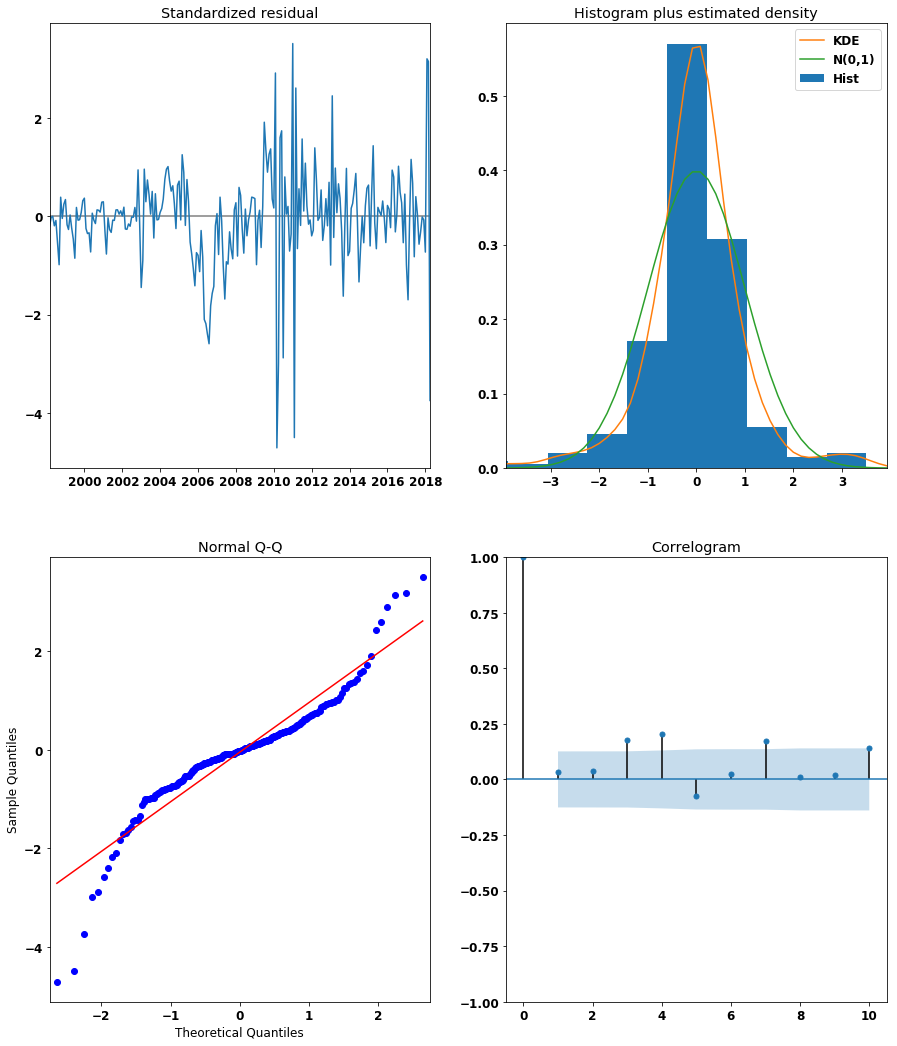

In [26]:
hf.diagnostics_plot(model=SARIMA_MODEL)

Based on the results of the plot diagnostics, we see that our data is not normally distributed. From here, we will continue to further look into our model and attempt to improve the results by removing outliers and the residuals that are causing issues within our model.

## Making predictions using our model parameters 

In [27]:
central_fl.idxmin()

value   1996-04-01
dtype: datetime64[ns]

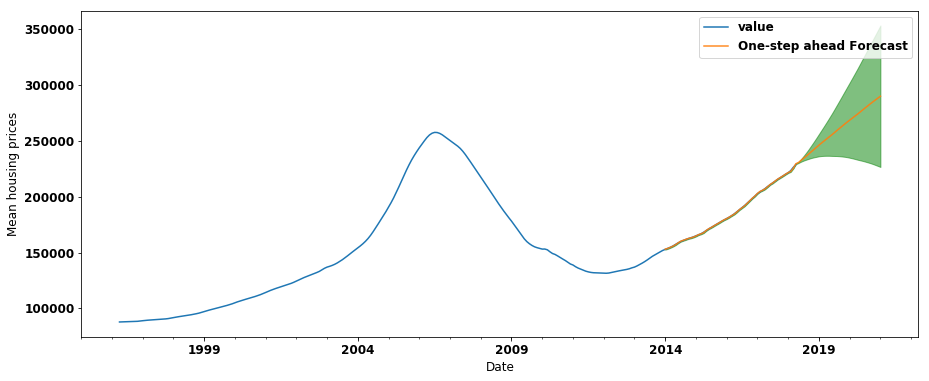

The Mean Squared Error of our forecasts is 51361.05


In [28]:
hf.one_step_ahead_forecast(df=central_fl, start_date='2014', end_date='2021', arima_model=SARIMA_MODEL)

### Dynamic forecasting of the data


The Mean Squared Error of our Dynamic forecasts is 52496946.2


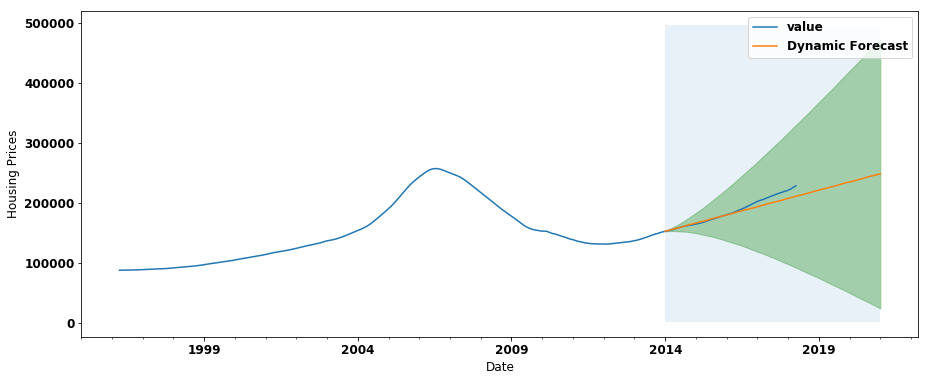

In [29]:
hf.dynamic_prediction(df=central_fl, start_date='2014', end_date='2021', arima_model=SARIMA_MODEL)

Based on the results of our dynamic prediction, the housign prices are forecast to steadily increase into 2021

## Findng the best zip code within Orange County

To find the best zip code within the given area, we wil use the following formula to calculate the return of investment:

$$\large R.O.I = \frac{(GFI - CoI)}{CoI}$$

- ROI = Return of Investment
- GFI = Gain from Investment
- CoI = Cost of Investment

Our Cost of Ivestment will be the average of 2017, since we do not have a complete dataset for 2018


To calculate GFI, we will take our cost of investment and subtract it from the average predicted means from 2018 to 2021.

We will then use the formula above to calculate the return of investment for each zip code observed

In [38]:
## Zipcodes of Orange County, Florida
zipcodes = df_fl.loc[(df_fl.CountyName.isin(central_florida))].RegionName.unique()

In [39]:
ROI_list = []
model_list = []

## Loop to get each zip code and calculate return on ivestment ##
for code in zipcodes:

    zip_df = df_fl.loc[(df_fl.RegionName==code), ['value']].resample('MS').mean()
    zip_model = hf.model_SARIMA(zip_df, order=order, s_order=s_order)

    pred = zip_model.get_prediction(start=pd.to_datetime('2014'), end=pd.to_datetime('2021'))

    ## Define the initial cost of investment as of 2017 ##
    cost_of_investment = zip_df['2017'].value.mean()

    ## Calculate gain from investmnt from 2018 up to 2021 ##
    gain_from_investment = pred.predicted_mean['2018':].mean()

    ## calculate Return of Investment for the observed zip code
    ROI = (gain_from_investment - cost_of_investment)/cost_of_investment
    ROI_list.append(ROI)
    model_list.append(zip_model)

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWa

In [40]:
df_results = pd.DataFrame(data=list(zip(zipcodes, ROI_list, model_list)), columns=['zip_code','ROI','model'])
# df_results['county'] = df_results.zip_code.apply(lambda x: central_fl[(df_fl.RegionName == x)].CountyName.unique())

# Step 6: Interpreting Results

Based on the results of our model, the top 5 zip codes to purchase a house from 2018 -2021 are as follows:
    

In [46]:
df_results.sort_values(by='ROI', ascending=False, inplace=True)
df_results['county'] = df_results.zip_code.apply(
    lambda x: df_fl[df_fl.RegionName==x].CountyName.unique())    

df_results.head(10)

,zip_code,ROI,model,county
223,34785,0.821538,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Sumter]
79,34652,0.729564,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
122,34691,0.642348,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
239,34488,0.580343,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Marion]
212,34690,0.561948,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
249,33513,0.534331,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Sumter]
92,32117,0.482835,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Volusia]
49,33881,0.477594,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Polk]
221,32976,0.475470,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Brevard]
318,32764,0.469361,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Brevard]


In [47]:
df_results.tail(10)

,zip_code,ROI,model,county
39,32714,0.063576,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Seminole]
114,33541,0.060517,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
98,33618,0.057098,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Hillsborough]
295,32124,0.056498,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Volusia]
227,33843,0.055844,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Polk]
178,32836,0.051416,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Orange]
222,33715,0.040957,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pinellas]
282,34484,0.014895,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Sumter]
95,33626,0.013987,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Hillsborough]
210,33598,-0.009668,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Hillsborough]


## Conclusion

Based on the results of our modeling and testing, the best zip code in Orange County to purchase a home is 32839.
The return on investment for this home is listed at 4.

My recommmendation would be to purchase a house within the area code of 34785 of Sumter County.

## Future Works

In the future, I would like to implement a means to automatically optimize the models generated, to see if the best model maybe one that was not ranked as high as the top 5.